![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All imports

In [39]:
!pip install mujoco

# Set up GPU rendering.
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
from IPython.display import HTML

def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())


clear_output()

# MuJoCo basics

We begin by defining and loading a simple model:

In [4]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

The `xml` string is written in MuJoCo's [MJCF](http://www.mujoco.org/book/modeling.html), which is an [XML](https://en.wikipedia.org/wiki/XML#Key_terminology)-based modeling language.
  - The only required element is `<mujoco>`. The smallest valid MJCF model is `<mujoco/>` which is a completely empty model.
  - All physical elements live inside the `<worldbody>` which is always the top-level body and constitutes the global origin in Cartesian coordinates.
  - We define two geoms in the world named `red_box` and `green_sphere`.
  - **Question:** The `red_box` has no position, the `green_sphere` has no type, why is that?
    - **Answer:** MJCF attributes have *default values*. The default position is `0 0 0`, the default geom type is `sphere`. The MJCF language is described in the documentation's [XML Reference chapter](https://mujoco.readthedocs.io/en/latest/XMLreference.html).

The `from_xml_string()` method invokes the model compiler, which creates a binary `mjModel` instance.

## mjModel

MuJoCo's `mjModel`, contains the *model description*, i.e., all quantities which *do not change over time*. The complete description of `mjModel` can be found at the end of the header file [`mjmodel.h`](https://github.com/google-deepmind/mujoco/blob/main/include/mujoco/mjmodel.h). Note that the header files contain short, useful inline comments, describing each field.

Examples of quantities that can be found in `mjModel` are `ngeom`, the number of geoms in the scene and `geom_rgba`, their respective colors:

In [5]:
model.ngeom

2

In [6]:
model.geom_rgba

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

## Named access

The MuJoCo Python bindings provide convenient [accessors](https://mujoco.readthedocs.io/en/latest/python.html#named-access) using names. Calling the `model.geom()` accessor without a name string generates a convenient error that tells us what the valid names are.

In [7]:
try:
  model.geom()
except KeyError as e:
  print(e)

"Invalid name ''. Valid names: ['green_sphere', 'red_box']"


Calling the named accessor without specifying a property will tell us what all the valid properties are:

In [8]:
model.geom('green_sphere')

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.   , 0.005, 0.   ])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

Let's read the `green_sphere`'s rgba values:

In [10]:
model.geom('green_sphere').rgba

array([0., 1., 0., 1.], dtype=float32)

This functionality is a convenience shortcut for MuJoCo's [`mj_name2id`](https://mujoco.readthedocs.io/en/latest/APIreference.html?highlight=mj_name2id#mj-name2id) function:

In [11]:
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

Similarly, the read-only `id` and `name` properties can be used to convert from id to name and back:

In [12]:
print('id of "green_sphere": ', model.geom('green_sphere').id)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

id of "green_sphere":  1
name of geom 1:  green_sphere
name of body 0:  world


Note that the 0th body is always the `world`. It cannot be renamed.

The `id` and `name` attributes are useful in Python comprehensions:

In [13]:
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

## `mjData`
`mjData` contains the *state* and quantities that depend on it. The state is made up of time, [generalized](https://en.wikipedia.org/wiki/Generalized_coordinates) positions and generalized velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. In order to make a new `mjData`, all we need is our `mjModel`

In [14]:
data = mujoco.MjData(model)

`mjData` also contains *functions of the state*, for example the Cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [15]:
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


Wait, why are both of our geoms at the origin? Didn't we offset the green sphere? The answer is that derived quantities in `mjData` need to be explicitly propagated (see [below](#scrollTo=QY1gpms1HXeN)). In our case, the minimal required function is [`mj_kinematics`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-kinematics), which computes global Cartesian poses for all objects (excluding cameras and lights).

In [16]:
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


# Basic rendering, simulation, and animation

In order to render we'll need to instantiate a `Renderer` object and call its `render` method.

We'll also reload our model to make the colab's sections independent.

""

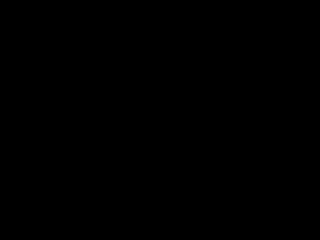

In [23]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
  media.show_image(renderer.render())

Hmmm, why the black pixels?

**Answer:** For the same reason as above, we first need to propagate the values in `mjData`. This time we'll call [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference/APIfunctions.html#mj-forward), which invokes the entire pipeline up to the computation of accelerations i.e., it computes $\dot x = f(x)$, where $x$ is the state. This function does more than we actually need, but unless we care about saving computation time, it's good practice to call `mj_forward` since then we know we are not missing anything.

We also need to update the `mjvScene` which is an object held by the renderer describing the visual scene. We'll later see that the scene can include visual objects which are not part of the physical model.

""

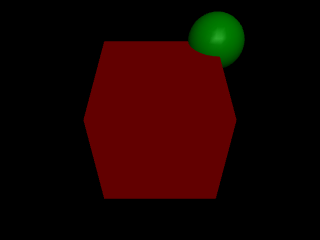

In [24]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

This worked, but this image is a bit dark. Let's add a light and re-render.

""

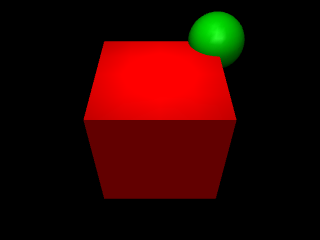

In [25]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

Much better!

Note that all values in the `mjModel` instance are writable. While it's generally not recommended to do this but rather to change the values in the XML, because it's easy to make an invalid model, some values are safe to write into, for example colors:

""

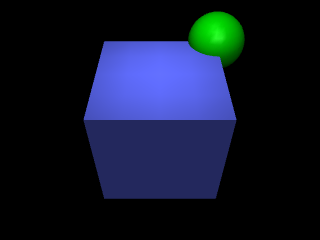

In [26]:
# Run this cell multiple times for different colors
model.geom('red_box').rgba[:3] = np.random.rand(3)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data)

  media.show_image(renderer.render())

# Simulation

Now let's simulate and make a video. We'll use MuJoCo's main high level function `mj_step`, which steps the state $x_{t+h} = f(x_t)$.

Note that in the code block below we are *not* rendering after each call to `mj_step`. This is because the default timestep is 2ms, and we want a 60fps video, not 500fps.

In [41]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

display_video(frames, framerate)

/tmp/ipykernel_70208/4288868434.py:72: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


Hmmm, the video is playing, but nothing is moving, why is that?

This is because this model has no [degrees of freedom](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FDegrees_of_freedom_(mechanics)) (DoFs). The things that move (and which have inertia) are called *bodies*. We add DoFs by adding *joints* to bodies, specifying how they can move with respect to their parents. Let's make a new body that contains our geoms, add a hinge joint and re-render, while visualizing the joint axis using the visualization option object `MjvOption`.

In [49]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

display_video(frames, framerate)

/tmp/ipykernel_70208/4288868434.py:72: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


Note that we rotated the `box_and_sphere` body by 30° around the Z (vertical) axis, with the directive `euler="0 0 -30"`. This was made to emphasize that the poses of elements in the [kinematic tree](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FKinematic_chain) are always with respect to their *parent body*, so our two geoms were also rotated by this transformation.

Physics options live in `mjModel.opt`, for example the timestep:

In [44]:
model.opt.timestep

0.002

Let's flip gravity and re-render:

In [46]:
print('default gravity', model.opt.gravity)
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

# media.show_video(frames, fps=60)
display_video(frames, 60)

default gravity [ 0.  0. 10.]
flipped gravity [ 0.  0. 10.]


/tmp/ipykernel_70208/4288868434.py:72: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


We could also have done this in XML using the top-level `<option>` element:
```xml
<mujoco>
  <option gravity="0 0 10"/>
  ...
</mujoco>
```

### Understanding Degrees of Freedom

In the real world, all rigid objects have 6 degrees-of-freedom: 3 translations and 3 rotations. Real-world joints act as constraints, removing relative degrees-of-freedom from bodies connected by joints. Some physics simulation software use this representation which is known as the "Cartesian" or "subtractive" representation, but it is inefficient. MuJoCo uses a representation known as the "Lagrangian", "generalized" or "additive" representation, whereby objects have no degrees of freedom unless explicitly added using joints.

Our model, which has a single hinge joint, has one degree of freedom, and the entire state is defined by this joint's angle and angular velocity. These are the system's generalized position and velocity.

In [50]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

Total number of DoFs in the model: 1
Generalized positions: [-0.114]
Generalized velocities: [0.987]


MuJoCo's use of generalized coordinates is the reason that calling a function (e.g. [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-forward)) is required before rendering or reading the global poses of objects – Cartesian positions are *derived* from the generalized positions and need to be explicitly computed.

# Example: Simulating free bodies with the self-inverting "tippe-top"

A free body is a body with a [free joint](https://www.google.com/url?sa=D&q=https%3A%2F%2Fmujoco.readthedocs.io%2Fen%2Flatest%2FXMLreference.html%3Fhighlight%3Dfreejoint%23body-freejoint) having 6 DoFs, i.e., 3 translations and 3 rotations. We could give our `box_and_sphere` body a free joint and watch it fall, but let's look at something more interesting. A "tippe top" is a spinning toy which flips itself ([video](https://www.youtube.com/watch?v=kbYpVrdcszQ), [Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). We model it as follows:

""

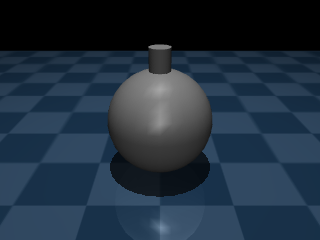

In [61]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, camera="closeup")

  media.show_image(renderer.render())

Note several new features of this model definition:
1. A 6-DoF free joint is added with the `<freejoint/>` clause.
2. We use the `<option/>` clause to set the integrator to the 4th order [Runge Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). Runge-Kutta has a higher rate of convergence than the default Euler integrator, which in many cases increases the accuracy at a given timestep size.
3. We define the floor's grid material inside the `<asset/>` clause and reference it in the `"floor"` geom.
4. We use an invisible and non-colliding box geom called `ballast` to move the top's center-of-mass lower. Having a low center of mass is (counter-intuitively) required for the flipping behavior to occur.
5. We save our initial spinning state as a *keyframe*. It has a high rotational velocity around the Z-axis, but is not perfectly oriented with the world, which introduces the symmetry-breaking required for the flipping.
6. We define a `<camera>` in our model, and then render from it using the `camera` argument to `update_scene()`.
Let us examine the state:


In [52]:
print('positions', data.qpos)
print('velocities', data.qvel)

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


The velocities are easy to interpret, 6 zeros, one for each DoF. What about the length 7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a *unit quaternion*. 3D orientations are represented with **4** numbers while angular velocities are **3** numbers. For more information see the Wikipedia article on [quaternions and spatial rotation](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).

Let's make a video:

In [63]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, "closeup")
      pixels = renderer.render()
      frames.append(pixels)

display_video(frames, framerate)

/tmp/ipykernel_70208/4288868434.py:72: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


### Measuring values from `mjData`
As mentioned above, the `mjData` structure contains the dynamic variables and intermediate results produced by the simulation which are *expected to change* on each timestep. Below we simulate for 2000 timesteps and plot the angular velocity of the top and height of the stem as a function of time.

In [66]:
timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, 0)
while data.time < duration:
  mujoco.mj_step(model, data)
  timevals.append(data.time)
  angular_velocity.append(data.qvel[3:6].copy())
  stem_height.append(data.geom_xpos[2,2]);

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')


<Figure size 600x800 with 2 Axes>

<Figure size 600x800 with 2 Axes>

<Figure size 600x800 with 2 Axes>

# Example: A chaotic pendulum

Below is a model of a chaotic pendulum, similar to [this one](https://www.exploratorium.edu/exhibits/chaotic-pendulum) in the San Francisco Exploratorium.

""

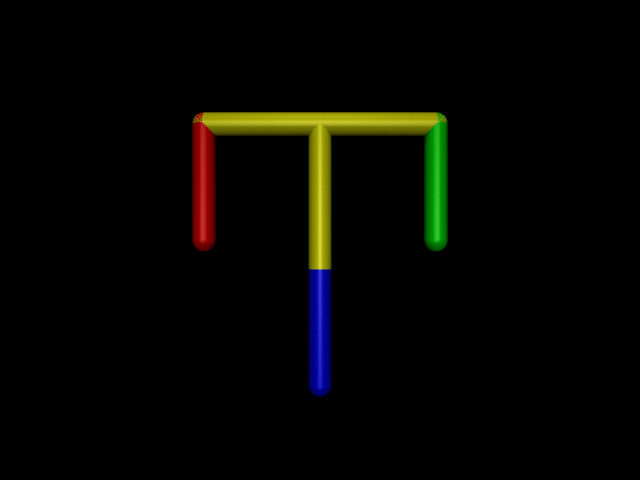

In [67]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

## Timing
Let's see a video of it in action while we time the components:

In [69]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
# media.show_video(frames, fps=framerate)
display_video(frames, framerate)

simulation:  6.48 μs/step  (154275Hz)
rendering:    821 μs/frame ( 1217Hz)




/tmp/ipykernel_70208/4288868434.py:72: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


Note that rendering is **much** slower than the simulated physics.

## Chaos
This is a [chaotic](https://en.wikipedia.org/wiki/Chaos_theory) system (small pertubations in initial conditions accumulate quickly):

In [ ]:
PERTURBATION = 1e-7
SIM_DURATION = 10 # seconds
NUM_REPEATS = 8

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
angle = np.zeros(n_steps)
energy = np.zeros(n_steps)

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):
  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 10 # root joint velocity
  # perturb initial velocities
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

  # simulate
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    angle[i] = data.joint('root').qpos
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy')
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
plt.tight_layout()

## Timestep and accuracy
**Question:** Why is the energy varying at all? There is no friction or damping, this system should conserve energy.

**Answer:** Because of the discretization of time.

If we decrease the timestep we'll get better accuracy and better energy conservation:

In [ ]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))

# prepare plotting axes
_, ax = plt.subplots(1, 1)

for dt in TIMESTEPS:
   # set timestep, print
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps)

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 9 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True);
plt.tight_layout()

## Timestep and divergence
When we increase the time step, the simulation quickly diverges:

In [ ]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -1.5, 7))

# get plotting axes
ax = plt.gca()

for dt in TIMESTEPS:
  # set timestep
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps) * np.nan
  speed = np.zeros(n_steps) * np.nan

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 11 # set root joint velocity

  # simulate
  print('simulating {} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    if data.warning.number.any():
      warning_index = np.nonzero(data.warning.number)[0][0]
      warning = mujoco.mjtWarning(warning_index).name
      print(f'stopped due to divergence ({warning}) at timestep {i}.\n')
      break
    sim_time[i] = data.time
    energy[i] = sum(abs(data.qvel))
    speed[i] = np.linalg.norm(data.qvel)

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))
  ax.set_yscale('log')

# finalize plot
ax.set_ybound(1, 1e3)
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

# Contacts

Let's go back to our box and sphere example and give it a free joint:

In [ ]:
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
data = mujoco.MjData(model)
height = 400
width = 600

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())

Let render this body rolling on the floor, in slow-motion, while visualizing contact points and forces:

In [ ]:
n_frames = 200
height = 240
width = 320
frames = []

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3)

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/120.0: #1/4x real time
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "track", options)
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=30)

## Analysis of contact forces

Let's rerun the above simulation (with a different random initial condition) and
plot some values related to the contacts

In [ ]:
n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon
  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("box_and_sphere").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')

plt.tight_layout()

## Friction

Let's see the effect of changing friction values

In [ ]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/>
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_resetData(model, data)
  for i in range(n_frames):
    while data.time < i/30.0:
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "y")
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=30)

# Tendons, actuators and sensors

In [ ]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
height = 480
width = 480

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())

actuated bat and passive "piñata":

In [ ]:
n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/fps:
      mujoco.mj_step(model, data)
      times.append(data.time)
      sensordata.append(data.sensor('accelerometer').data.copy())
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=fps)

Let's plot the values measured by our accelerometer sensor:

In [ ]:
ax = plt.gca()

ax.plot(np.asarray(times), np.asarray(sensordata), label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

Note how the moments when the body is hit by the bat are clearly visible in the accelerometer measurements.

# Advanced rendering

Like joint visualization, additional rendering options are exposed as parameters to the `render` method.

Let's bring back our first model:

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [ ]:
#@title Enable transparency and frame visualization {vertical-output: true}

scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, scene_option=scene_option)
  frame = renderer.render()
  media.show_image(frame)

In [ ]:
#@title Depth rendering {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  # update renderer to render depth
  renderer.enable_depth_rendering()

  # reset the scene
  renderer.update_scene(data)

  # depth is a float array, in meters.
  depth = renderer.render()

  # Shift nearest values to the origin.
  depth -= depth.min()
  # Scale by 2 mean distances of near rays.
  depth /= 2*depth[depth <= 1].mean()
  # Scale to [0, 255]
  pixels = 255*np.clip(depth, 0, 1)

  media.show_image(pixels.astype(np.uint8))

In [ ]:
#@title Segmentation rendering {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  renderer.disable_depth_rendering()

  # update renderer to render segmentation
  renderer.enable_segmentation_rendering()

  # reset the scene
  renderer.update_scene(data)

  seg = renderer.render()

  # Display the contents of the first channel, which contains object
  # IDs. The second channel, seg[:, :, 1], contains object types.
  geom_ids = seg[:, :, 0]
  # Infinity is mapped to -1
  geom_ids = geom_ids.astype(np.float64) + 1
  # Scale to [0, 1]
  geom_ids = geom_ids / geom_ids.max()
  pixels = 255*geom_ids
  media.show_image(pixels.astype(np.uint8))

## The camera matrix

For a description of the camera matrix see the article [Camera matrix](https://en.wikipedia.org/wiki/Camera_matrix) on Wikipedia.

In [ ]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

In [ ]:
#@title Project from world to camera coordinates {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  renderer.disable_segmentation_rendering()
  # reset the scene
  renderer.update_scene(data)

  # Get the world coordinates of the box corners
  box_pos = data.geom_xpos[model.geom('red_box').id]
  box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
  box_size = model.geom_size[model.geom('red_box').id]
  offsets = np.array([-1, 1]) * box_size[:, None]
  xyz_local = np.stack(list(itertools.product(*offsets))).T
  xyz_global = box_pos[:, None] + box_mat @ xyz_local

  # Camera matrices multiply homogenous [x, y, z, 1] vectors.
  corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
  corners_homogeneous[:3, :] = xyz_global

  # Get the camera matrix.
  m = compute_camera_matrix(renderer, data)

  # Project world coordinates into pixel space. See:
  # https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
  xs, ys, s = m @ corners_homogeneous
  # x and y are in the pixel coordinate system.
  x = xs / s
  y = ys / s

  # Render the camera view and overlay the projected corner coordinates.
  pixels = renderer.render()
  fig, ax = plt.subplots(1, 1)
  ax.imshow(pixels)
  ax.plot(x, y, '+', c='w')
  ax.set_axis_off()

## Modifying the scene

Let's add some arbitrary geometry to the `mjvScene`.

In [ ]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/16  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    # append data to the traces
    positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
    times.append(data.time)
    speeds.append(get_geom_speed(model, data, "green_sphere"))
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      modify_scene(renderer.scene)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

## Camera control

Cameras can be controlled dynamically in order to achieve cinematic effects. Run the three cells below to see the difference between rendering from a static and moving camera.

The camera-control code smoothly transitions between two trajectories, one orbiting a fixed point, the other tracking a moving object. Parameter values in the code were obtained by iterating quickly on low-res videos.

In [ ]:
#@title Load the "dominos" model

dominos_xml = """
<mujoco>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" reflectance=".2"/>
  </asset>

  <statistic meansize=".01"/>

  <visual>
    <global offheight="2160" offwidth="3840"/>
    <quality offsamples="8"/>
  </visual>

  <default>
    <geom type="box" solref=".005 1"/>
    <default class="static">
      <geom rgba=".3 .5 .7 1"/>
    </default>
  </default>

  <option timestep="5e-4"/>

  <worldbody>
    <light pos=".3 -.3 .8" mode="trackcom" diffuse="1 1 1" specular=".3 .3 .3"/>
    <light pos="0 -.3 .4" mode="targetbodycom" target="box" diffuse=".8 .8 .8" specular=".3 .3 .3"/>
    <geom name="floor" type="plane" size="3 3 .01" pos="-0.025 -0.295  0" material="grid"/>
    <geom name="ramp" pos=".25 -.45 -.03" size=".04 .1 .07" euler="-30 0 0" class="static"/>
    <camera name="top" pos="-0.37 -0.78 0.49" xyaxes="0.78 -0.63 0 0.27 0.33 0.9"/>

    <body name="ball" pos=".25 -.45 .1">
      <freejoint name="ball"/>
      <geom name="ball" type="sphere" size=".02" rgba=".65 .81 .55 1"/>
    </body>

    <body pos=".26 -.3 .03" euler="0 0 -90.0">
      <freejoint/>
      <geom size=".0015 .015 .03" rgba="1 .5 .5 1"/>
    </body>

    <body pos=".26 -.27 .04" euler="0 0 -81.0">
      <freejoint/>
      <geom size=".002 .02 .04" rgba="1 1 .5 1"/>
    </body>

    <body pos=".24 -.21 .06" euler="0 0 -63.0">
      <freejoint/>
      <geom size=".003 .03 .06" rgba=".5 1 .5 1"/>
    </body>

    <body pos=".2 -.16 .08" euler="0 0 -45.0">
      <freejoint/>
      <geom size=".004 .04 .08" rgba=".5 1 1 1"/>
    </body>

    <body pos=".15 -.12 .1" euler="0 0 -27.0">
      <freejoint/>
      <geom size=".005 .05 .1" rgba=".5 .5 1 1"/>
    </body>

    <body pos=".09 -.1 .12" euler="0 0 -9.0">
      <freejoint/>
      <geom size=".006 .06 .12" rgba="1 .5 1 1"/>
    </body>

    <body name="seasaw_wrapper" pos="-.23 -.1 0" euler="0 0 30">
      <geom size=".01 .01 .015" pos="0 .05 .015" class="static"/>
      <geom size=".01 .01 .015" pos="0 -.05 .015" class="static"/>
      <geom type="cylinder" size=".01 .0175" pos="-.09 0 .0175" class="static"/>
      <body name="seasaw" pos="0 0 .03">
        <joint axis="0 1 0"/>
        <geom type="cylinder" size=".005 .039" zaxis="0 1 0" rgba=".84 .15 .33 1"/>
        <geom size=".1 .02 .005" pos="0 0 .01" rgba=".84 .15 .33 1"/>
      </body>
    </body>

    <body name="box" pos="-.3 -.14 .05501" euler="0 0 -30">
      <freejoint name="box"/>
      <geom name="box" size=".01 .01 .01" rgba=".0 .7 .79 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(dominos_xml)
data = mujoco.MjData(model)


In [ ]:
#@title Render from fixed camera

duration = 2.5  # (seconds)
framerate = 60  # (Hz)
height = 1024
width = 1440

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, camera='top')
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

In [ ]:
#@title Render from moving camera

duration = 3  # (seconds)
height = 1024
width = 1440

# find time when box is thrown (speed > 2cm/s)
throw_time = 0.0
mujoco.mj_resetData(model, data)
while data.time < duration and not throw_time:
  mujoco.mj_step(model, data)
  box_speed = np.linalg.norm(data.joint('box').qvel[:3])
  if box_speed > 0.02:
    throw_time = data.time
assert throw_time > 0

def mix(time, t0=0.0, width=1.0):
  """Sigmoidal mixing function."""
  t = (time - t0) / width
  s = 1 / (1 + np.exp(-t))
  return 1 - s, s

def unit_cos(t):
  """Unit cosine sigmoid from (0,0) to (1,1)."""
  return 0.5 - np.cos(np.pi*np.clip(t, 0, 1))/2

def orbit_motion(t):
  """Return orbit trajectory."""
  distance = 0.9
  azimuth = 140 + 100 * unit_cos(t)
  elevation = -30
  lookat = data.geom('floor').xpos.copy()
  return distance, azimuth, elevation, lookat

def track_motion():
  """Return box-track trajectory."""
  distance = 0.08
  azimuth = 280
  elevation = -10
  lookat = data.geom('box').xpos.copy()
  return distance, azimuth, elevation, lookat

def cam_motion():
  """Return sigmoidally-mixed {orbit, box-track} trajectory."""
  d0, a0, e0, l0 = orbit_motion(data.time / throw_time)
  d1, a1, e1, l1 = track_motion()
  mix_time = 0.3
  w0, w1 = mix(data.time, throw_time, mix_time)
  return w0*d0+w1*d1, w0*a0+w1*a1, w0*e0+w1*e1, w0*l0+w1*l1

# Make a camera.
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)

# Simulate and display video.
framerate = 60  # (Hz)
slowdown = 4    # 4x slow-down
mujoco.mj_resetData(model, data)
frames = []
with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate * slowdown:
      cam.distance, cam.azimuth, cam.elevation, cam.lookat = cam_motion()
      renderer.update_scene(data, cam)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)